In [ ]:
# Import Libraries
import itertools
import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
from tqdm import tqdm
import yfinance as yf

In [ ]:
df = pd.read_csv('MP_strategy_data.csv', parse_dates=True, index_col = 0)
df.rename(columns = {'UKIPI Index':'UK_IP','IP Index': 'USA_IP'}, inplace= True)

In [ ]:
# Take Log and Calculate Metrics
df['DEXUSUK'] = np.log(df['DEXUSUK'])
df['s_future'] = df['DEXUSUK'].shift(-1)
df['s_change'] = df['s_future'] - df['DEXUSUK']

df

,DEXUSUK,s_diff_current,s_diff_future,USA_PCE,UK_PCE,USA_IP,UK_IP,s_future,s_change
Date,,,,,,,,,
1989-03-31,0.521884,-0.0588,0.0038,7.30869,8.729165,NaN,NaN,0.524137,0.002252
1989-04-30,0.524137,0.0038,-0.1175,8.58106,8.622486,62.0592,74.3,0.452031,-0.072106
1989-05-31,0.452031,-0.1175,-0.0225,7.83945,8.797702,62.0424,76.2,0.437610,-0.014421
1989-06-30,0.437610,-0.0225,0.1170,7.47627,8.777054,61.6948,74.2,0.510426,0.072816
1989-07-31,0.510426,0.1170,-0.0930,7.26957,8.824701,61.6915,74.2,0.452985,-0.057441
...,...,...,...,...,...,...,...,...,...
2023-07-31,0.251303,0.0148,-0.0190,5.91807,6.400000,102.3002,96.4,0.236415,-0.014888
2023-08-31,0.236415,-0.0190,-0.0453,5.42273,5.900000,103.1900,95.4,0.199998,-0.036417
2023-09-30,0.199998,-0.0453,-0.0079,5.54651,5.900000,103.2411,95.0,0.193509,-0.006489


## 1). Bring all variables to time $t$

In [ ]:
# UK PCE
UK_PCE_value_t = df.UK_PCE.shift(1)

# USA PCE
USA_PCE_value_t = df.USA_PCE.shift(1)

# UK IP
UK_IP_value_t = df.UK_IP.shift(2)

# USA IP
USA_IP_value_t = df.USA_IP.shift(1)

In [ ]:
# Join new dataset and drop NAs
df_at_t = pd.concat([df.DEXUSUK, df.s_future, df.s_change, USA_PCE_value_t, UK_PCE_value_t, USA_IP_value_t, UK_IP_value_t], axis=1)
df_at_t = df_at_t.dropna()

# Calculate PCE Difference
df_at_t['pce_diff'] = df_at_t['USA_PCE'] - df_at_t['UK_PCE']
df_at_t

,DEXUSUK,s_future,s_change,USA_PCE,UK_PCE,USA_IP,UK_IP,pce_diff
Date,,,,,,,,
1989-06-30,0.437610,0.510426,0.072816,7.83945,8.797702,62.0424,74.3,-0.958252
1989-07-31,0.510426,0.452985,-0.057441,7.47627,8.777054,61.6948,76.2,-1.300784
1989-08-31,0.452985,0.479025,0.026041,7.26957,8.824701,61.6915,74.2,-1.555131
1989-09-30,0.479025,0.455841,-0.023184,7.50000,7.733588,61.0978,74.2,-0.233588
1989-10-31,0.455841,0.450757,-0.005084,7.31556,7.946888,61.6949,74.4,-0.631328
...,...,...,...,...,...,...,...,...
2023-06-30,0.239725,0.251303,0.011578,5.88445,6.500000,103.1512,94.6,-0.615550
2023-07-31,0.251303,0.236415,-0.014888,5.32991,6.400000,102.9240,94.7,-1.070090
2023-08-31,0.236415,0.199998,-0.036417,5.91807,6.400000,102.3002,93.9,-0.481930


## 2). Calculate the Gap

In [ ]:
# Calculate Actual and Potential values
a = df_at_t["USA_IP"]
p = a.rolling(12).mean()

# Calculate Gap
gap = a - p

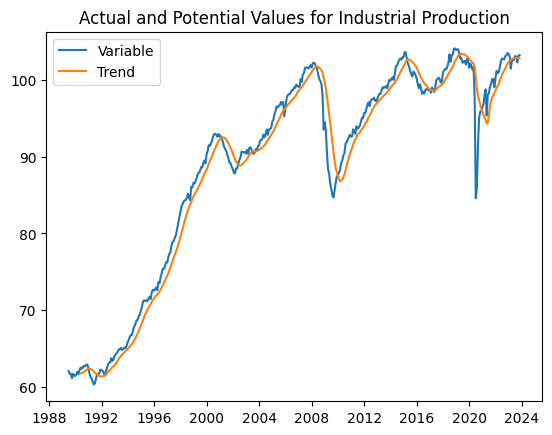

In [ ]:
# Plot
plt.plot(a, label='Variable')
plt.plot(p, label='Trend')
plt.title("Actual and Potential Values for Industrial Production")
plt.legend()
plt.show()

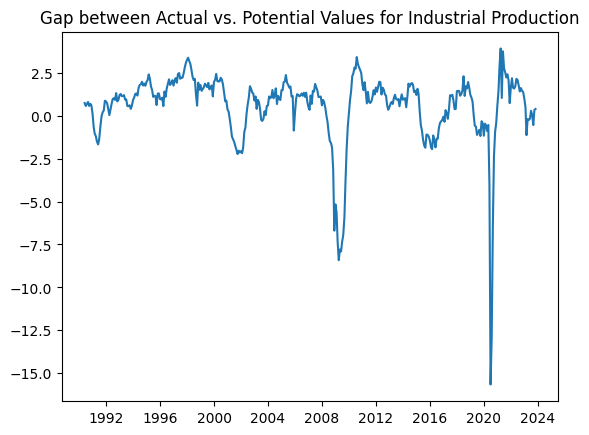

In [ ]:
# Plot Gap
plt.plot(gap)
plt.title("Gap between Actual vs. Potential Values for Industrial Production")
plt.show()

In [ ]:
# Set Training Length --> 5 years in test set
mos = (len(df_at_t)-60)

train_df = df_at_t[:mos]
test_df = df_at_t[mos:]

In [ ]:
# Define array of window sizes
window_size = itertools.product(
    np.arange(2, 13, dtype=int),
    np.arange(2, 13, dtype=int)
)

In [ ]:
# Hyperparameter Tuning
results_temp = {}

temp_wind = 18

for key in tqdm(window_size):

    # Create copy of df
    train_df_copy = train_df.copy()

    h_us = key[0]
    h_uk = key[1]

    # Create Gap
    usa_gap = train_df_copy['USA_IP'] - train_df_copy['USA_IP'].rolling(h_us).mean()
    uk_gap = train_df_copy['UK_IP'] - train_df_copy['UK_IP'].rolling(h_uk).mean()

    train_df_copy['gap_diff'] = usa_gap - uk_gap
    train_df_copy.dropna()

    # Train Data on chosen gap
    for i in range(temp_wind, len(train_df_copy)):

        # we regress the change in the exchange rate on the taylor rule fundamentals
        tmp = smf.ols(formula = 's_change ~ pce_diff + gap_diff', data = train_df_copy.iloc[:i]).fit()

        # make a prediction for the next period
        prediction = tmp.predict(train_df_copy[['pce_diff', 'gap_diff']].iloc[i:i+1])

        # Assign the prediction to the correct index
        train_df_copy.loc[train_df_copy.index[i], 's_change_fitted'] = prediction.iloc[0]

    # Drop Prediction NAs
    train_df_copy = train_df_copy.dropna()

    # Calculate and Store MSE
    mse_train = mean_squared_error(train_df_copy['s_change'], train_df_copy['s_change_fitted'])

    results_temp[tuple(key)] = mse_train

0it [00:00, ?it/s]

121it [02:58,  1.48s/it]


In [ ]:
# Store Results
results_hyperparameters = pd.DataFrame()
results_hyperparameters['h_us'] = pd.DataFrame(results_temp.keys())[0]
results_hyperparameters['h_uk'] = pd.DataFrame(results_temp.keys())[1]
results_hyperparameters['train_mse'] = pd.DataFrame(results_temp.values())

# Sort the results to find the combination that yields the min MSE
results_hyperparameters = results_hyperparameters.sort_values(by = 'train_mse', ascending=True)
results_hyperparameters.head()

,h_us,h_uk,train_mse
0,2,2,0.000768
29,4,9,0.000773
28,4,8,0.000773
11,3,2,0.000773
1,2,3,0.000773


In [ ]:
# Heatmap Function
def heatmap(x, y, metric, values, title):

    # specify the columns I will be pulling from the results
    p2p = values[[x, y, metric]]

    # If p > 2, we need to group
    heat = np.round(p2p.groupby([x,y]).mean(),8)
    heat = heat.unstack()[metric]

    # round labels
    heat.index = np.round(heat.index,2)
    heat.columns = np.round(heat.columns,2)
    heat = heat.iloc[::-1]
    # make plot
    f, ax = plt.subplots(figsize=(11.5, 5))
    ax = sns.heatmap(heat, fmt='.1g', cmap = "RdBu")
    ax.set_title(title,size = 14)
    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.set_xlabel("Window Size UK\n(months)")
    ax.set_ylabel("Windwo Size US\n(months)")
    ax.collections[0].colorbar.set_label('Train MSE')
    sns.set(font_scale=1)
    plt.show()

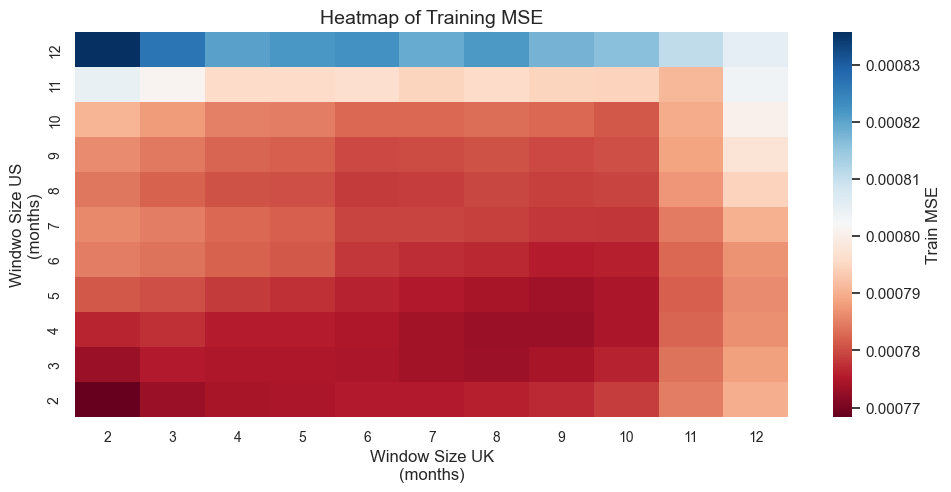

In [ ]:
# Create Heatmap
heatmap(x = 'h_us', y = 'h_uk', metric = 'train_mse', values = results_hyperparameters, title = 'Heatmap of Training MSE')

In [ ]:
# Rerun Model with Optimal Hyperparams
h_us = 2
h_uk = 2

# Create Gap
usa_gap = test_df['USA_IP'] - test_df['USA_IP'].rolling(h_us).mean()
uk_gap = test_df['UK_IP'] - test_df['UK_IP'].rolling(h_uk).mean()

test_df['gap_diff'] = usa_gap - uk_gap
test_df.dropna()

# Initialize Variable
test_df['s_change_fitted'] = np.nan

# Deploy Strategy
for i in range(temp_wind, len(test_df)):

    # we regress the change in the exchange rate on the taylor rule fundamentals
    tmp = smf.ols(formula = 's_change ~ pce_diff + gap_diff', data = test_df.iloc[:i]).fit()

    # make a prediction for the next period
    prediction = tmp.predict(test_df[['pce_diff', 'gap_diff']].iloc[i:i+1])

    # Assign the prediction to the correct index
    test_df.loc[test_df.index[i], 's_change_fitted'] = prediction.iloc[0]

# Drop Prediction NAs
test_df = test_df.dropna()

# Calculate MSEs
mse_test = mean_squared_error(test_df['s_change'], test_df['s_change_fitted'])

# Calculate Forecasts
test_df['s_forecast'] = test_df['s_change_fitted'] + test_df['DEXUSUK']
test_df['error'] = test_df['s_future'] - test_df['s_forecast']

/var/folders/74/y9463jcd2d55bdm26zmn_wj80000gn/T/ipykernel_40103/4163972573.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['gap_diff'] = usa_gap - uk_gap
/var/folders/74/y9463jcd2d55bdm26zmn_wj80000gn/T/ipykernel_40103/4163972573.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['s_change_fitted'] = np.nan


In [ ]:
df_forecasts = test_df.dropna().copy()

# Go long if we forecast the exchange rate will increase, otherwise short
df_forecasts['signal'] = np.where(df_forecasts['s_change_fitted'] >= 0, 1, -1)

# calculate returns
df_forecasts['strategy_return'] = (np.exp((df_forecasts['signal']*df_forecasts['s_change']).cumsum())-1)*100
df_forecasts['returns'] = df_forecasts['signal']*df_forecasts['s_change']

df_forecasts

,DEXUSUK,s_future,s_change,USA_PCE,UK_PCE,USA_IP,UK_IP,pce_diff,gap_diff,s_change_fitted,s_forecast,error,signal,strategy_return,returns
Date,,,,,,,,,,,,,,,
2020-05-31,0.208639,0.212608,0.003969,-14.35745,1.5,97.6672,107.5,-15.85745,-2.83290,-0.063758,0.144880,0.067728,-1,-0.396152,-0.003969
2020-06-30,0.212608,0.272543,0.059935,-7.59651,1.3,84.5979,99.3,-8.89651,-2.43465,-0.006444,0.206164,0.066379,-1,-6.190512,-0.059935
2020-07-31,0.272543,0.290802,0.018259,-2.53002,1.5,85.9732,84.1,-4.03002,8.28765,-0.006792,0.265751,0.025051,-1,-7.887850,-0.018259
2020-08-31,0.290802,0.256269,-0.034533,-1.29010,1.8,91.5625,90.6,-3.09010,-0.45535,0.006135,0.296937,-0.040668,1,-11.014498,-0.034533
2020-09-30,0.256269,0.257197,0.000928,-0.66985,1.0,95.0144,100.2,-1.66985,-3.07405,-0.001093,0.255176,0.002021,-1,-11.097064,-0.000928
2020-10-31,0.257197,0.288032,0.030835,0.68290,1.4,95.8881,104.9,-0.71710,-1.91315,-0.000687,0.256510,0.031522,-1,-13.796546,-0.030835
2020-11-30,0.288032,0.312033,0.024001,0.81253,1.5,95.8444,107.2,-0.68747,-1.17185,0.001865,0.289897,0.022136,1,-11.702535,0.024001
2020-12-31,0.312033,0.316488,0.004455,-0.01908,1.2,96.4292,107.5,-1.21908,0.14240,0.004036,0.316069,0.000419,1,-11.308292,0.004455
2021-01-31,0.316488,0.332679,0.016191,0.41041,1.5,96.8564,107.3,-1.08959,0.31360,0.003972,0.320461,0.012219,1,-9.860581,0.016191


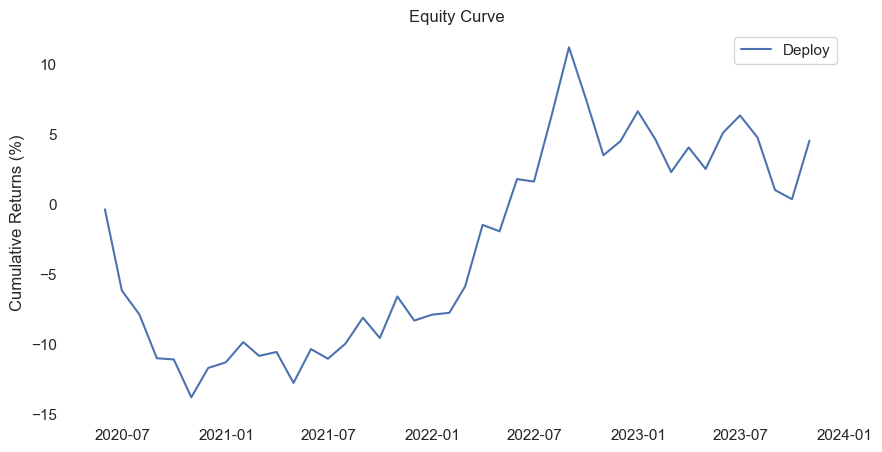

In [ ]:
# Equity Curve
plt.figure(figsize = (10, 5))
plt.plot(df_forecasts['strategy_return'])
plt.ylabel("Cumulative Returns (%)")
plt.title("Equity Curve")
plt.legend(["Deploy"])
plt.grid()
plt.show()

### DMW and CW Tests

In [ ]:
# Mean squared errors
## Taylor Rule Model
P = len(df_forecasts['error'][temp_wind:])
MSE_T = np.sum(np.square(df_forecasts['error'])[temp_wind:])/P
MSE_T

0.0006970889743617512

In [ ]:
## Random Walk
MSE_R = np.sum(np.square(df_forecasts['s_change'])[temp_wind:])/P
MSE_R

0.0006998504266798438

In [ ]:
## DMW statistic
## V_hat
error_R = df_forecasts['s_change'][temp_wind:].reset_index(drop=True)
error_T = df_forecasts['error'][temp_wind:].reset_index(drop=True)
tmp = np.square(error_R) - np.square(error_T) - (MSE_R - MSE_T)
V_hat = np.sum(np.square(tmp))/P

## Statistic
DMW = (MSE_R - MSE_T)/np.sqrt(V_hat/P)

print('Since the DMW statitsic is equal to ' + str(DMW) + ',' + ' which is less than the critical value (' + str(round(st.norm.ppf(.95),2)) + '),')
print('we fail to reject the null hypothesis that the MP model does not outperform the random walk model.')

Since the DMW statitsic is equal to 0.11217736508897423, which is less than the critical value (1.64),
we fail to reject the null hypothesis that the MP model does not outperform the random walk model.


In [ ]:
### CW statistic
tmp2 = np.sum(np.square(df_forecasts['s_change_fitted'][temp_wind:]))/P
CW = (MSE_R - MSE_T + tmp2)/np.sqrt(V_hat/P)

print('Since the CW statitsic is equal to ' + str(CW) + ',' + ' which is smaller than the critical value (' + str(round(st.norm.ppf(.95),2)) + '),')
print('we fail to reject the null hypothesis that the MP model does not outperform the random walk model.')

Since the CW statitsic is equal to 0.34630060882395236, which is smaller than the critical value (1.64),
we fail to reject the null hypothesis that the MP model does not outperform the random walk model.


### Metrics

In [ ]:
# Geometric Average Monthly     ##Is this all it is??
def geo_mean(value):
    return (value + 1).prod() ** (1 / len(value)) - 1

geo_mean(np.exp(df_forecasts['returns'])-1)

0.0007252459771782682

In [ ]:
# Standard Deviation        # Nathan's code had an error here and was just duplicated for both this and annualized so I think it's correct
df_forecasts['returns'].std()

0.025710401465145437

In [ ]:
# High/Low Months
df_forecasts['returns'].sort_values()

Date
2020-06-30   -0.059935
2022-10-31   -0.038084
2023-08-31   -0.036417
2020-08-31   -0.034533
2022-09-30   -0.033647
2020-10-31   -0.030835
2021-04-30   -0.024978
2023-02-28   -0.022567
2023-01-31   -0.018922
2021-11-30   -0.018541
2020-07-31   -0.018259
2021-09-30   -0.015908
2023-04-30   -0.014893
2023-07-31   -0.014888
2021-02-28   -0.010958
2021-06-30   -0.007720
2023-09-30   -0.006489
2022-04-30   -0.004685
2020-05-31   -0.003969
2022-06-30   -0.001725
2020-09-30   -0.000928
2022-01-31    0.001489
2021-03-31    0.003112
2020-12-31    0.004455
2021-12-31    0.004529
2022-11-30    0.009568
2023-06-30    0.011578
2021-07-31    0.012003
2021-01-31    0.016191
2023-03-31    0.017074
2022-02-28    0.020098
2022-12-31    0.020246
2021-08-31    0.020356
2020-11-30    0.024001
2023-05-31    0.024937
2021-05-31    0.027293
2021-10-31    0.032225
2022-05-31    0.037283
2023-10-31    0.040773
2022-07-31    0.044993
2022-08-31    0.045045
2022-03-31    0.045659
Name: returns, dtype: float64

In [ ]:
# ARoR
t = 3
(((df_forecasts['strategy_return'].iloc[-1]/100+1)**(1/t))-1)

0.014782580031812431

In [ ]:
# Annualized Standard Deviation
df_forecasts['returns'].std()*np.sqrt(12)

0.0890634432412504

In [ ]:
# Calculate Sharpe Ratio
rf = (1 + 0.0147)**(1/12) - 1  ## NEW RISK FREE RATE TAKEN FROM HRFI

excess = df_forecasts['returns'] - rf
excess.mean()/excess.std(ddof = 1)*np.sqrt(12)  ## This is really bad?

-0.022723540459739417

In [ ]:
# % of Winning Months
len(df_forecasts.loc[df_forecasts['returns'] > 0])/len(df_forecasts['returns'])

0.5

In [ ]:
# Calculate Max Drawdown
df_forecasts['c_max'] = df_forecasts['strategy_return'].cummax()
df_forecasts['dd'] = (df_forecasts['c_max'] - df_forecasts['strategy_return'])/df_forecasts['c_max']

df_forecasts['dd'].max()

0.970812562859683

In [ ]:
# Download SP500 Data
## Aggregate to Monthly level and Convert to Simple Returns
df_forecasts['sp500'] =(yf.download('^GSPC')[['Adj Close']].pct_change()+1).resample('M').prod()-1

# Put Returns in % Units
df_forecasts['M_Returns'] = df_forecasts['returns'] * 100
df_forecasts['sp500'] = df_forecasts['sp500'] * 100

# Set Risk Free Rate
df_forecasts['rfr'] = rf

# Calculate Excess Returns
df_forecasts['ex_ret'] = df_forecasts['M_Returns'] - df_forecasts['rfr']
df_forecasts['ex_sp500'] = df_forecasts['sp500'] - df_forecasts['rfr']

[*********************100%%**********************]  1 of 1 completed


In [ ]:
# Overall Alpha / Beta
smf.ols('ex_ret ~ ex_sp500', data = df_forecasts).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 ex_ret   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                 -0.018
Method:                 Least Squares   F-statistic:                    0.2699
Date:                Thu, 21 Mar 2024   Prob (F-statistic):              0.606
Time:                        02:22:46   Log-Likelihood:                -98.609
No. Observations:                  42   AIC:                             201.2
Df Residuals:                      40   BIC:                             204.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0619      0.408      0.152      0.880      -0.763       0.887
ex_sp500       0.0419      0.081      0.519      0.606      -0.121       0.205
==============================================================================
Omnibus:                        0.478   Durbin-Watson:                   1.798
Prob(Omnibus):                  0.788   Jarque-Bera (JB):                0.614
Skew:                          -0.109   Prob(JB):                        0.736
Kurtosis:                       2.449   Cond. No.                         5.17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
# Up Alpha / Beta

## Limit Data to where excess S&P 500 yielded a higher than 0% return
updf = df_forecasts.loc[df_forecasts['ex_sp500']> 0]

smf.ols('ex_ret ~ ex_sp500', data = updf).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 ex_ret   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.041
Method:                 Least Squares   F-statistic:                   0.01712
Date:                Thu, 21 Mar 2024   Prob (F-statistic):              0.897
Time:                        02:29:31   Log-Likelihood:                -61.742
No. Observations:                  26   AIC:                             127.5
Df Residuals:                      24   BIC:                             130.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.3877      1.009      0.384      0.704      -1.695       2.470
ex_sp500      -0.0261      0.200     -0.131      0.897      -0.438       0.386
==============================================================================
Omnibus:                        0.673   Durbin-Watson:                   1.838
Prob(Omnibus):                  0.714   Jarque-Bera (JB):                0.617
Skew:                          -0.335   Prob(JB):                        0.734
Kurtosis:                       2.653   Cond. No.                         9.87
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
# Down Alpha / Beta

## Limit Data to where excess S&P 500 yielded a lower than 0% return
ddf = df_forecasts.loc[df_forecasts['ex_sp500']< 0]

smf.ols('ex_ret ~ ex_sp500', data = ddf).fit().summary()

/Applications/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 ex_ret   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                 -0.062
Method:                 Least Squares   F-statistic:                    0.1268
Date:                Thu, 21 Mar 2024   Prob (F-statistic):              0.727
Time:                        02:30:05   Log-Likelihood:                -36.715
No. Observations:                  16   AIC:                             77.43
Df Residuals:                      14   BIC:                             78.97
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2125      1.264      0.168      0.869      -2.500       2.924
ex_sp500       0.0888      0.249      0.356      0.727      -0.446       0.623
==============================================================================
Omnibus:                        0.679   Durbin-Watson:                   2.221
Prob(Omnibus):                  0.712   Jarque-Bera (JB):                0.698
Skew:                           0.326   Prob(JB):                        0.705
Kurtosis:                       2.211   Cond. No.                         10.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
# Correlation
df_forecasts.corr()['sp500']

DEXUSUK            0.270926
s_future           0.213596
s_change          -0.135021
USA_PCE           -0.155559
UK_PCE            -0.231208
USA_IP            -0.251371
UK_IP              0.095920
pce_diff          -0.094886
gap_diff           0.095177
s_change_fitted   -0.082096
s_forecast         0.251621
error             -0.091990
signal             0.214300
strategy_return   -0.156230
returns            0.081862
c_max             -0.089332
dd                -0.169718
sp500              1.000000
M_Returns          0.081862
rfr                     NaN
ex_ret             0.081862
ex_sp500           1.000000
Name: sp500, dtype: float64